## Transient Universe emcee

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist

from sklearn.neighbors import KernelDensity

import emcee
#import pymc3
import corner

### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**

1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

Text(0.5, 1.0, 'Transient flux')

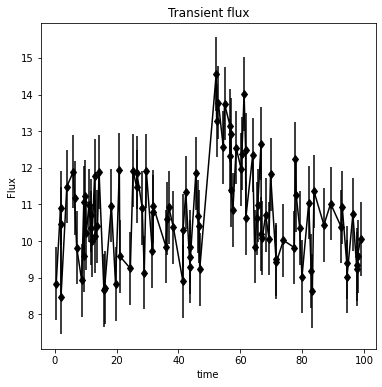

In [2]:
file = np.load('transient.npy')

time = file[:,0]
flux = file[:,1]
err_flux = file[:,2]

fig = plt.figure(figsize=(6,6))

#plt.plot(time,flux,c='black')
#plt.scatter(time,flux,c='black',s=10)
plt.errorbar(time,flux,err_flux,c='black',marker='d')
plt.xlabel('time')
plt.ylabel('Flux')
plt.title('Transient flux')

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 



In [3]:
# burst model:
def burst_model(params,t):
    '''burst model for the transient flux'''
    # extract the parameters
    t0 = params[0]
    b = params[1]
    A = params[2]
    alpha = params[3]
    
    func = np.zeros(len(t))
    
    for i in range(len(t)):
        if(t[i]<t0):
            func[i] = b
        elif(t[i]>=t0):
             func[i] = b + A*np.exp(-alpha*(t[i]-t0))
        
    return func
    
    #return b + A*np.exp(-alpha*(t-t0))

    
# log-Likelihood:
def logL(params,data,model=burst_model):
    """Gaussian log-likelihood of the model"""
    
    # load the data
    x,y,err_y = data
    
    # apply the model
    y_fit = model(params,x)
    
    return sum(scipy.stats.norm.logpdf(*args) for args in zip(y, y_fit, err_y)) # not normalized

# parameters estimation:
def best_params(model,data):
    '''estimate the best parameters with a minimization algorithm'''
    
    # define the initial condition
    init_params = np.array([49,9,4,1/20])
    
    neg_logL = lambda params: -logL(params, data, model)  # negative for the minimization
    
    return optimize.fmin_bfgs(neg_logL, init_params, disp=False)

[48.8627024  10.28787798  5.64254406  0.11890549]


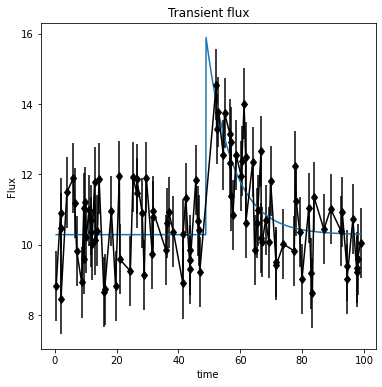

In [4]:
# initialize the fitting parameters and data
data_fit = np.array([time,flux,err_flux])

# get best-fit parameters 
fit_params = best_params(burst_model,data_fit)
print(fit_params)

# plot the fit result:
t_grid = np.linspace(time.min(),time.max(),1000)
burst_fit = burst_model(fit_params,t_grid) 

fig = plt.figure(figsize=(6,6))

#plt.plot(time,flux,c='black')
#plt.scatter(time,flux,c='black',s=10)
plt.errorbar(time,flux,err_flux,c='black',marker='d')
plt.xlabel('time')
plt.ylabel('Flux')
plt.title('Transient flux')

plt.plot(t_grid,burst_fit)


3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc3`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.


In [5]:
# prior
def Prior(params):
    prior_t0 = scipy.stats.uniform(0,100).pdf(params[0])
    prior_b = scipy.stats.uniform(0,50).pdf(params[1])
    prior_A = scipy.stats.uniform(0,50).pdf(params[2])
    prior_lnAlpha = scipy.stats.uniform(-5,5).pdf(np.log(params[3]))
    
    return prior_t0*prior_b*prior_A*prior_lnAlpha

# log-Likelihood:
def logL(params,data,model=burst_model):
    """Gaussian log-likelihood of the model"""
    
    # load the data
    x,y,err_y = data
    
    # apply the model
    y_fit = model(params,x)
    
    return sum(scipy.stats.norm.logpdf(*args) for args in zip(y, y_fit, err_y))

# log_posterior
def log_posterior(params,data,model):
    # compute the log-prior
    log_prior = np.log(Prior(params))
    
    # put control on the result of the prior
    if not np.isfinite(log_prior):
        return -np.inf
    else:
        return logL(params,data,model) + log_prior

In [6]:
# prepare the MCMC:
ndim = 4  # number of parameters in the model
nwalkers = 10 # number of MCMC walkers
nsteps = 5000  # number of MCMC steps to take **for each walker**

# initialize parameters 
np.random.seed(0)
starting_guesses = np.array([49,9,4,1/20])+1e-3*np.random.randn(nwalkers, ndim)

# run the MCMC: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data_fit,burst_model))
sampler.run_mcmc(starting_guesses, nsteps,progress=True)


  1%|          | 27/5000 [00:04<12:14,  6.77it/s]<ipython-input-5-901c761f414e>:25: RuntimeWarning: divide by zero encountered in log
  log_prior = np.log(Prior(params))
  1%|          | 39/5000 [00:05<11:36,  7.12it/s]<ipython-input-5-901c761f414e>:6: RuntimeWarning: invalid value encountered in log
  prior_lnAlpha = scipy.stats.uniform(-5,5).pdf(np.log(params[3]))
100%|██████████| 5000/5000 [13:09<00:00,  6.33it/s]


State([[46.94128583 10.39566118  9.21709681  0.16591136]
 [47.51208787 10.36756336  7.24991922  0.13241795]
 [48.2706891  10.34790915  4.70684435  0.10538646]
 [50.7531679  10.22572927  4.14933766  0.09698533]
 [47.32019547 10.40176028 11.24315652  0.17275101]
 [48.71040992 10.35805758  6.62335899  0.14740304]
 [48.41091036 10.38867172  4.08273092  0.10829387]
 [47.40942959 10.38491737  9.32639756  0.13317299]
 [48.27420839 10.47593072  8.09434325  0.16093562]
 [48.69550595 10.33284961  8.27609587  0.16512811]], log_prob=[-156.11015859 -154.96005406 -155.68511501 -155.16366242 -157.54215413
 -155.22839154 -157.45244057 -158.97147316 -156.72757325 -156.45004789], blobs=None, random_state=('MT19937', array([3713706053, 3605161317,  582705492, 3249322281, 1550618392,
        548592574, 3780488417, 3332403913, 2051386114, 3280940930,
       1738427924, 1152841831,   11979337,  448520674, 2889110033,
       2831467799, 2852266830, 2034151303, 3308695354, 2241919416,
       2261425348,  3081

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

In [7]:
# get the autocorrelation time to determine the burn-in
tau = sampler.get_autocorr_time()
print(tau)

[60.87843822 62.03327732 58.1870795  63.9523436 ]


(1610, 4)


Text(0.5, 0, 'steps')

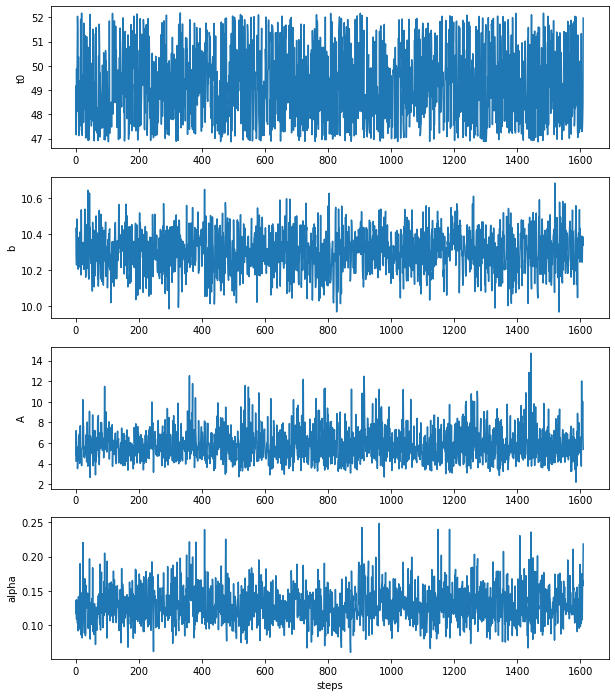

In [8]:
# away a few times this number of steps as “burn-in” ; thin by about half the autocorrelation time
chain = sampler.get_chain(flat=True,thin=30,discard=150)
print(chain.shape)

#plot the chain
labels = np.array(['t0','b','A','alpha'])

fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(10,12))
for i in range(chain.shape[1]):
    ax = ax.ravel()
    ax[i].plot(chain[:,i])
    ax[i].set_ylabel(labels[i])
    
plt.xlabel('steps')


5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

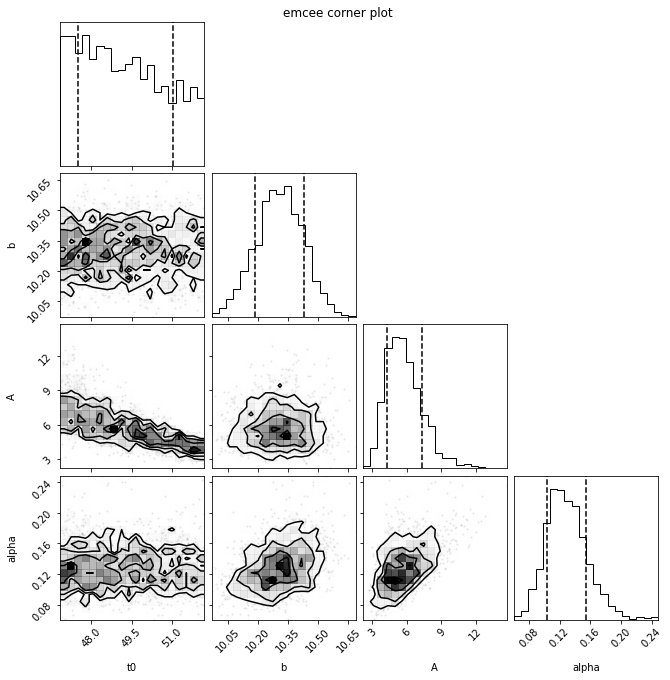

In [9]:
fig = corner.corner(chain, labels=labels,quantiles=(0.16, 0.84));
_ = fig.suptitle("emcee corner plot")

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

In [10]:
N = 100
random_burst_chain = np.zeros([N],dtype=object)

for i in range(N):
    idx_chain = np.random.choice(np.arange(0,chain.shape[0]))
    random_burst_chain[i] = burst_model(chain[idx_chain],t_grid)

Text(0, 0.5, 'flux')

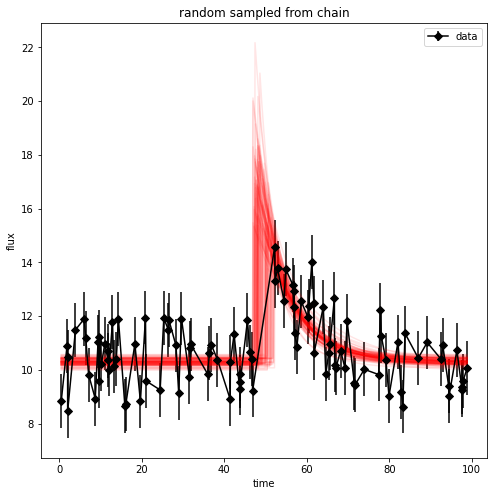

In [11]:
fig = plt.figure(figsize=(8,8))

for i in range(random_burst_chain.shape[0]):
    plt.plot(t_grid,random_burst_chain[i],c='red',alpha=0.1)
    
#plt.plot(time,flux,err_flux,color='black')
plt.errorbar(time,flux,err_flux,marker='D',color='black',label='data')
plt.title('random sampled from chain')
plt.legend()
plt.xlabel('time')
plt.ylabel('flux')

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 

In [12]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(chain[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>